In [46]:
import matplotlib.pyplot as plt
import numpy as np
# import brian2 as b2
import hh
import importlib
# importlib.reload(hh)
from ipywidgets import *
%matplotlib widget

Simulate slowly increasing current

In [82]:
# Precompute outputs
ls_Iexts = []
ls_arr_outs = []
for Iamp in np.arange(-3, -14, -0.25):
    neuron = hh.HH(tFinal=100)
    neuron.initialize()
    
    Iext = np.zeros(neuron.time.shape[0])
    Iext[100:] = Iamp
    
    neuron.simulate(Iext)
    ls_Iexts.append(Iext)

    arr_append = np.dstack((neuron.arr_h, neuron.arr_m, neuron.arr_n, neuron.arr_V))
    ls_arr_outs.append(arr_append)

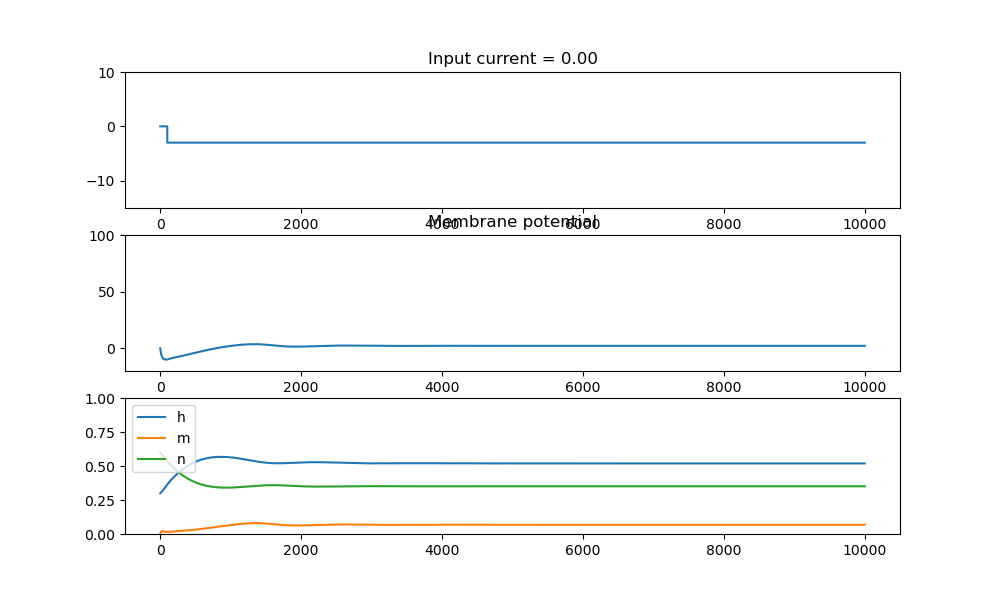

interactive(children=(IntSlider(value=0, description='idx', max=43), Output()), _dom_classes=('widget-interact…

<function __main__.update(idx=0)>

In [85]:
# Interactive plot
idx = 0
arr_out = ls_arr_outs[idx].squeeze()
Iext = ls_Iexts[idx]
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(3, 1, 1)
l1 = ax.plot(Iext)
ax.set_ylim(-15, 10)
ax.set_title(f'Input current = {Iext.max():.2f}')

ax = fig.add_subplot(3, 1, 2)
l2 = ax.plot(-arr_out[:, 3])
ax.set_ylim(-20, 100)
ax.set_title('Membrane potential')

ax = fig.add_subplot(3, 1, 3)
l3 = ax.plot(arr_out[:, 0], label='h')
l4 = ax.plot(arr_out[:, 1], label='m')
l5 = ax.plot(arr_out[:, 2], label='n')
ax.legend(loc=(1.05, 0.5))
ax.set_ylim(0, 1)
plt.show()
plt.subplots_adjust(hspace=0.5)

def update(idx=0):
    arr_out = ls_arr_outs[idx].squeeze()
    Iext = ls_Iexts[idx]
    l1[0].set_ydata(Iext)
    l2[0].set_ydata(-arr_out[:, 3])
    l3[0].set_ydata(arr_out[:, 0])
    l4[0].set_ydata(arr_out[:, 1])
    l5[0].set_ydata(arr_out[:, 2])
    fig.canvas.draw_idle()

interact(update, idx=(0, len(ls_Iexts)-1, 1))

In [43]:
# Simple constant conductance model in brian2
# C*dV/dt = I - gk(V-Ek)
b2.start_scope()
b2.defaultclock.dt = 0.01*b2.ms

gk = 36*b2.msiemens/b2.cm**2
Ek = -77*b2.mV
C = 1*b2.uF/b2.cm**2
eqs = '''
dv/dt = (I-gk*(v-Ek))/C : volt
I : amp/meter**2
'''
G = b2.NeuronGroup(1, eqs)
G.I = 0.5*b2.nA/b2.cm**2
for i in range(10):
    M = b2.StateMonitor(G, 'v', record=True)
    b2.run(100*b2.ms)
    G.I += 0.5*b2.nA/b2.cm**2

INFO       No numerical integration method specified for group 'neurongroup_2', using method 'exact' (took 0.07s). [brian2.stateupdaters.base.method_choice]


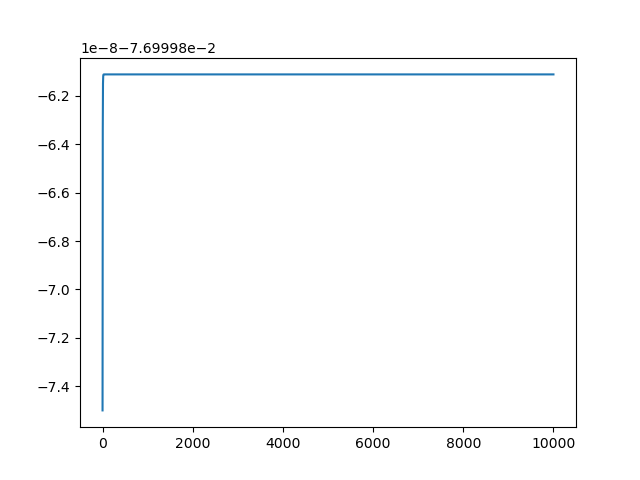

In [44]:
plt.figure()
plt.plot(M.v.flatten())
plt.show()

In [ ]:
defaultclock.dt = 0.01*ms

morpho = Cylinder(length=10*cm, diameter=2*238*um, n=1000, type='axon')

El = 10.613*mV
ENa = 115*mV
EK = -12*mV
gl = 0.3*msiemens/cm**2
gNa0 = 120*msiemens/cm**2
gK = 36*msiemens/cm**2

# Typical equations
eqs = '''
# The same equations for the whole neuron, but possibly different parameter values
# distributed transmembrane current
INa = gNa * m**3 * h * (ENa-v) : amp/meter**2
Il = gl * (El-v) : amp/meter**2
IK = gK * n**4 * (EK-v) : amp/meter**2
Im = INa + Il + IK : amp/meter**2
I : amp (point current) # applied current
dm/dt = alpham * (1-m) - betam * m : 1
dn/dt = alphan * (1-n) - betan * n : 1
dh/dt = alphah * (1-h) - betah * h : 1
alpham = (0.1/mV) * 10*mV/exprel((-v+25*mV)/(10*mV))/ms : Hz
betam = 4 * exp(-v/(18*mV))/ms : Hz
alphah = 0.07 * exp(-v/(20*mV))/ms : Hz
betah = 1/(exp((-v+30*mV) / (10*mV)) + 1)/ms : Hz
alphan = (0.01/mV) * 10*mV/exprel((-v+10*mV)/(10*mV))/ms : Hz
betan = 0.125*exp(-v/(80*mV))/ms : Hz
gNa : siemens/meter**2
'''

neuron = SpatialNeuron(morphology=morpho, model=eqs, method="exponential_euler",
                       refractory="m > 0.4", threshold="m > 0.5",
                       Cm=1*uF/cm**2, Ri=35.4*ohm*cm)
neuron.v = 0*mV
neuron.h = 1
neuron.m = 0
neuron.n = .5
neuron.I = 0*amp
neuron.gNa = gNa0
M = StateMonitor(neuron, 'v', record=True)
M2 = StateMonitor(neuron, 'INa', record=True)
spikes = SpikeMonitor(neuron)

neuron.v = -60*mV
run(50*ms, report='text')
# neuron.I[0] = 1*uA # current injection at one end
neuron.v = -30*mV
run(50*ms)
neuron.v = -60*mV
# neuron.I = 0*amp
run(50*ms, report='text')

# Calculation of velocity
# slope, intercept, r_value, p_value, std_err = stats.linregress(spikes.t/second,
#                                                 neuron.distance[spikes.i]/meter)
# print("Velocity = %.2f m/s" % slope)

subplot(211)
for i in range(100):
    plot(M.t/ms, M.v.T[:, i*10]/mV)
ylabel('v')
subplot(212)
# for i in range(100):
plot(M2.t/ms, M2.INa.T[:, i*10]/mV)
# plot(spikes.t/ms, spikes.i*neuron.length[0]/cm, '.k')
# plot(spikes.t/ms, (intercept+slope*(spikes.t/second))/cm, 'r')
# xlabel('Time (ms)')
# ylabel('Position (cm)')
# show()